# CNN DenseNet Build

# 1. Library Import

In [1]:
import numpy as np
import os
import matplotlib
from matplotlib import pyplot as plt
import SimpleITK as sitk
import json
from skimage import morphology
from skimage import measure

### Tensorflow 2.0 ###
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import Input
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import regularizers
from tensorflow.keras import utils
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import backend as K

# 2. Dataset

## 2.1 Sample 2D

In [2]:
(x_train, y_train), (x_test, y_test)=keras.datasets.mnist.load_data(path='minist.npz')
print(x_train.shape, y_train.shape)

(60000, 28, 28) (60000,)


In [3]:
x_train_list = []
x_test_list = []
for i, i_ in enumerate(x_train[:1000]):
    arr = np.zeros(shape=(32, 32))
    arr[:28,:28] = x_train[i]
    x_train_list.append(arr)
for i, i_ in enumerate(x_test[:500]):
    arr = np.zeros(shape=(32, 32))
    arr[:28,:28] = x_test[i]
    x_test_list.append(arr)

x_train1 = np.expand_dims(np.array(x_train_list), axis=-1)
x_test1 = np.expand_dims(np.array(x_test_list), axis=-1)
print(x_train1.shape, x_test1.shape)

(1000, 32, 32, 1) (500, 32, 32, 1)


In [4]:
y_train_list = []
y_test_list = []
for i, i_ in enumerate(y_train[:1000]):
    zero = [0]*10
    zero[i_] = 1
    y_train_list.append(zero)

for i, i_ in enumerate(y_test[:500]):
    zero = [0]*10
    zero[i_] = 1
    y_test_list.append(zero)    
    
y_train1 = np.array(y_train_list)
y_test1 = np.array(y_test_list)
print(y_train1.shape, y_test1.shape)

(1000, 10) (500, 10)


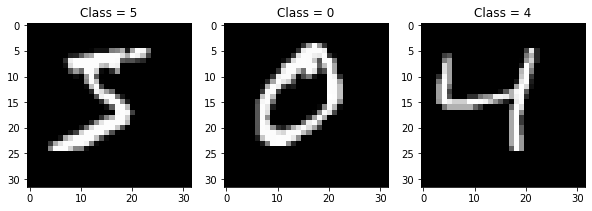

In [5]:
plt.figure(figsize=(10,10))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(x_train1[i][...,0], cmap='gray')
    plt.title('Class = {}'.format(y_train[i]))

# 3. Model Build

## 3.1 Keras Application

In [12]:
import tensorflow.keras.applications.densenet as dense
model = dense.DenseNet121(weights='imagenet', include_top=False, input_shape=(32, 32, 3))
model.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 38, 38, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 16, 16, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 16, 16, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

## 3.2 DenseNet Block

In [72]:
class DenseNet:
    def __init__(self, par_dic):
        # parameters
        self.input_size = par_dic['input_size']
        self.creg_weight = par_dic['conv_reg_weight']
        self.dreg_weight = par_dic['dens_reg_weight']
        self.act_func = par_dic['act_func']
        self.dens_num = par_dic['dens_num']
        self.dens_count = par_dic['dens_count']
        self.drop_rate = par_dic['drop_rate']
        self.output_count = par_dic['output_count']
        self.output_act = par_dic['output_act']
        
    def __call__(self, model_name, array_dim):
        if model_name == 'DenseNet121':
            if array_dim == '2d':
                inputs = layers.Input(shape=self.input_size, name = 'input_1')
                conv1 = self.conv1_block2(inputs, self.creg_weight)  # Blcok1
                conv2 = self.dens_block2(conv1, 2, 6, self.creg_weight) # Dense Block1
                pool2 = self.trans_block2(conv2, 2, 128, self.creg_weight) # Trans Block1
                conv3 = self.dens_block2(pool2, 3, 12, self.creg_weight) # Dense Block2
                pool3 = self.trans_block2(conv3, 3, 256, self.creg_weight) # Trans Block2
                conv4 = self.dens_block2(pool3, 4, 24, self.creg_weight) # Dense Block3
                pool4 = self.trans_block2(conv4, 4, 512, self.creg_weight) # Trans Block3
                conv5 = self.dens_block2(pool4, 5, 16, self.creg_weight) # Dense Block4
                bn = layers.BatchNormalization(axis=-1, name='bn')(conv5)
                relu = layers.Activation('relu', name='relu')(bn)
                gap = self.gap_block2(relu, self.drop_rate)
                outputs = layers.Dense(self.output_count, activation=self.output_act, 
                                       name='output_1')(gap)
                model = Model(inputs, outputs)
                return model
            elif array_dim == '3d':
                inputs = layers.Input(shape=self.input_size, name = 'input_1')
                conv1 = self.conv1_block3(inputs, self.creg_weight)  # Blcok1
                conv2 = self.dens_block3(conv1, 2, 6, self.creg_weight) # Dense Block1
                pool2 = self.trans_block3(conv2, 2, 128, self.creg_weight) # Trans Block1
                conv3 = self.dens_block3(pool2, 3, 12, self.creg_weight) # Dense Block2
                pool3 = self.trans_block3(conv3, 3, 256, self.creg_weight) # Trans Block2
                conv4 = self.dens_block3(pool3, 4, 24, self.creg_weight) # Dense Block3
                pool4 = self.trans_block3(conv4, 4, 512, self.creg_weight) # Trans Block3
                conv5 = self.dens_block3(pool4, 5, 16, self.creg_weight) # Dense Block4
                bn = layers.BatchNormalization(axis=-1, name='bn')(conv5)
                relu = layers.Activation('relu', name='relu')(bn)
                gap = self.gap_block3(relu, self.drop_rate)
                outputs = layers.Dense(self.output_count, activation=self.output_act, 
                                       name='output_1')(gap)
                model = Model(inputs, outputs)
                return model
    
    def conv1_block2(self, lr_conv, reg_weight):
        # layer blcok
        lr_conv = layers.ZeroPadding2D(3, name = 'zero_padding2d')(lr_conv)
        lr_conv = layers.Conv2D(64, 7, 2, activation=None, padding='valid', kernel_initializer='he_normal',
                                kernel_regularizer=reg_weight, name='conv1/conv')(lr_conv)
        lr_conv = layers.BatchNormalization(axis=-1, name='conv1/bn')(lr_conv)
        lr_conv = layers.Activation('relu', name='conv1/relu')(lr_conv)
        lr_conv = layers.ZeroPadding2D(1, name = 'zero_padding2d_1')(lr_conv)
        lr_conv = layers.MaxPool2D(3, 2, padding='valid', name='pool1')(lr_conv)
        return lr_conv
    
    def conv1_block3(self, lr_conv, reg_weight):
        # layer blcok
        lr_conv = layers.ZeroPadding3D(3, name = 'zero_padding3d')(lr_conv)
        lr_conv = layers.Conv3D(64, 7, 2, activation=None, padding='valid', kernel_initializer='he_normal',
                                kernel_regularizer=reg_weight, name='conv1/conv')(lr_conv)
        lr_conv = layers.BatchNormalization(axis=-1, name='conv1/bn')(lr_conv)
        lr_conv = layers.Activation('relu', name='conv1/relu')(lr_conv)
        lr_conv = layers.ZeroPadding3D(1, name = 'zero_padding3d_1')(lr_conv)
        lr_conv = layers.MaxPool3D(3, 2, padding='valid', name='pool1')(lr_conv)
        return lr_conv
    
    def dens_block2(self, bl_input, num, block_n, reg_weight):
        for i in range(block_n):
            if i == 0:
                lr_input = bl_input
            else:
                lr_input = lr_output
            lr_conv = layers.BatchNormalization(axis=-1, name='conv{}_block{}_0_bn'.format(num, i+1))(lr_input)
            lr_conv = layers.Activation('relu', name='conv{}_block{}_0_relu'.format(num, i+1))(lr_conv)
            lr_conv = layers.Conv2D(128,1,1, activation=None, padding='same', kernel_initializer='he_normal', 
                                    kernel_regularizer=reg_weight, 
                                    name='conv{}_block{}_1_conv'.format(num, i+1))(lr_conv)
            lr_conv = layers.BatchNormalization(axis=-1, name='conv{}_block{}_1_bn'.format(num, i+1))(lr_conv)
            lr_conv = layers.Activation('relu', name='conv{}_block{}_1_relu'.format(num, i+1))(lr_conv)
            lr_conv = layers.Conv2D(32,3,1, activation=None, padding='same', kernel_initializer='he_normal', 
                                    kernel_regularizer=reg_weight, 
                                    name='conv{}_block{}_2_conv'.format(num, i+1))(lr_conv)
            lr_output = layers.concatenate([lr_input, lr_conv], axis=-1, 
                                           name='conv{}_block{}_concat'.format(num, i+1))
        return lr_output
    
    def dens_block3(self, bl_input, num, block_n, reg_weight):
        for i in range(block_n):
            if i == 0:
                lr_input = bl_input
            else:
                lr_input = lr_output
            lr_conv = layers.BatchNormalization(axis=-1, name='conv{}_block{}_0_bn'.format(num, i+1))(lr_input)
            lr_conv = layers.Activation('relu', name='conv{}_block{}_0_relu'.format(num, i+1))(lr_conv)
            lr_conv = layers.Conv3D(128,1,1, activation=None, padding='same', kernel_initializer='he_normal', 
                                    kernel_regularizer=reg_weight, 
                                    name='conv{}_block{}_1_conv'.format(num, i+1))(lr_conv)
            lr_conv = layers.BatchNormalization(axis=-1, name='conv{}_block{}_1_bn'.format(num, i+1))(lr_conv)
            lr_conv = layers.Activation('relu', name='conv{}_block{}_1_relu'.format(num, i+1))(lr_conv)
            lr_conv = layers.Conv3D(32,3,1, activation=None, padding='same', kernel_initializer='he_normal', 
                                    kernel_regularizer=reg_weight, 
                                    name='conv{}_block{}_2_conv'.format(num, i+1))(lr_conv)
            lr_output = layers.concatenate([lr_input, lr_conv], axis=-1, 
                                           name='conv{}_block{}_concat'.format(num, i+1))
        return lr_output
    
    def trans_block2(self, bl_input, num, filter_n, reg_weight):
        lr_trans = layers.BatchNormalization(axis=-1, name='pool{}_bn'.format(num))(bl_input)
        lr_trans = layers.Activation('relu', name='pool{}_relu'.format(num))(lr_trans)
        lr_trans = layers.Conv2D(filter_n,1,1, activation=None, padding='same', kernel_initializer='he_normal', 
                                 kernel_regularizer=reg_weight, name='pool{}_conv'.format(num))(lr_trans)
        lr_trans = layers.AveragePooling2D(2, 2, padding='valid', name='pool{}_pool'.format(num))(lr_trans)
        return lr_trans
           
    def trans_block3(self, bl_input, num, filter_n, reg_weight):
        lr_trans = layers.BatchNormalization(axis=-1, name='pool{}_bn'.format(num))(bl_input)
        lr_trans = layers.Activation('relu', name='pool{}_relu'.format(num))(lr_trans)
        lr_trans = layers.Conv3D(filter_n,1,1, activation=None, padding='same', kernel_initializer='he_normal', 
                                 kernel_regularizer=reg_weight, name='pool{}_conv'.format(num))(lr_trans)
        lr_trans = layers.AveragePooling3D(2, 2, padding='valid', name='pool{}_pool'.format(num))(lr_trans)
        return lr_trans
        
    def gap_block2(self, lr_io, drop_rate):
        lr_gap = layers.GlobalAveragePooling2D(name='gap1_gap')(lr_io)
        lr_drop = layers.Dropout(drop_rate, name='gap1_drop')(lr_gap)
        return lr_drop
    
    def gap_block3(self, lr_io, drop_rate):
        lr_gap = layers.GlobalAveragePooling3D(name='gap1_gap')(lr_io)
        lr_drop = layers.Dropout(drop_rate, name='gap1_drop')(lr_gap)
        return lr_drop

In [73]:
par_dic = {'input_size': (32, 32, 32, 1), 
           'reg_val': 'conv/dens : none/none', 
           'conv_reg_weight': None, 
           'dens_reg_weight': None, 
           'act_func': 'relu', 
           'dens_num': 2,
           'dens_count': [1000, 500], 
           'drop_rate': 0.5, 
           'output_count': 10, 
           'output_act': 'softmax'}

densm = DenseNet(par_dic)
model = densm('DenseNet121', '3d')
model.summary()

Model: "model_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 32,  0                                            
__________________________________________________________________________________________________
zero_padding3d (ZeroPadding3D)  (None, 38, 38, 38, 1 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv3D)             (None, 16, 16, 16, 6 22016       zero_padding3d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 16, 16, 16, 6 256         conv1/conv[0][0]                 
___________________________________________________________________________________________